**Stock Market Reseach Proposal**

**Background**
Stocks generally follow the overall market based on their "beta score", which represents how proportionally they follow the market.  A stock typically breaks pace with the market on news related to the company. However, once the news break, the stock experiences an immediate movement and there is very little time to take action.

**Problem**
Our firm would like to understand how long the effects of positive news lasts, and if it is a good bet to buy a stock the day following an unusually positive movement.

**Hypothesis**
A stock which trades significantly higher due to positive news will continue to outperform the market over the next 30 trading day.

**Experiment**

Control Group:  Entire population.

Test Group:   Stocks which significantly outperformed the market the prior day.

*Note: Using daily performance for Dow 30 components dating back to 1982

**Analysis**
Determine if there is a difference in how stocks performed over the next month in the Control Group vs the Test Group.
Look at the results across all stocks, and individually by stock.

**Benchmark**
Perform t-test on two samples to determine if the test group outperforms the control group with 95% confidence.

Perform the t-test across all stocks, and by stock.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats



In [8]:
dow30 = ['PFE',
'AAPL',
'PG',
'INTC',
'MRK',
'KO',
'WMT',
'MCD',
'VZ',
'JNJ',
'UNH',
'UTX',
'CSCO',
'HD',
'V',
'AXP',
'DIS',
'NKE',
'XOM',
'MMM',
'IBM',
'CVX',
'WBA',
'TRV',
'MSFT',
'JPM',
'GS',
'BA',
'DWDP',
'CAT']

In [9]:
data = pd.DataFrame(data=[])

#------ Read and load data for 30 Dow Components ---------
for stock in dow30:
    temp = pd.read_table(str.lower(stock) + '.us.txt', delimiter=',', )
    temp['stock'] = str.lower(stock)
    data = data.append(temp, ignore_index=True, sort=True )

#Convert Date into datetime
data['Date'] = pd.to_datetime(data['Date'])

#-----------Data Engineering-----------------
#Create PctChange column and Day of Week
data['PctChg'] = round((data.Close - data.Open) / data.Open * 100,2)
data['dayofweek'] = data['Date'].dt.dayofweek  #0 is Monday

#-------Create a DataFrame (m_df) to reflect the overall Market ------------
m_close = round(data['Close'].groupby(data['Date']).mean(),2)
m_open = round(data['Open'].groupby(data['Date']).mean(),2)
m_df = pd.DataFrame({'Close_M' : m_close, 'Open_M' : m_open})
m_df['Chg_M'] = round((m_df.Close_M - m_df.Open_M) / m_df.Open_M * 100,2)


#New column with the Market Close value 30 days from now
m_df['Close_M_N'] = m_df['Close_M'].shift(-30)
m_df['Chg_M_N'] = round((m_df.Close_M_N - m_df.Open_M) / m_df.Open_M * 100,2)


#---------Merge Market dataFrame with Stock dataFrame-------------
data = pd.merge(data, m_df, how='left', left_on='Date', right_index=True)


#New column indicating if stock outperformed market on that day
data['Outperform'] = data.PctChg - data.Chg_M


#------- Use Shift: New column with the Outperform value from Yesterday ---------
Yesterday = []

for stock in dow30:
    stock = str.lower(stock)
    temp = data.loc[data.stock == stock, 'Outperform'].shift(1).tolist()
    Yesterday = Yesterday + temp

#Add list of Yesterday    
data['Y_Outperform'] = Yesterday

#Update any NaN to zero
data.at[data.Y_Outperform.isna(),'Y_Outperform'] = 0



#----- Use Shift: New column with the Stock Close value 30 days from now ------
forward = []

for stock in dow30:
    stock = str.lower(stock)
    temp = data.loc[data.stock == stock, 'Close'].shift(-30).tolist()
    forward = forward + temp

#Add list of forward    
data['Close_N'] = forward

#Update any NaN to Close
data.at[data.Y_Outperform.isna(),'Close_N'] = data['Close']



#New column with the Stock Pct Change 30 days from now
data['Chg_N'] = round((data.Close_N - data.Open) / data.Open * 100,2)
data['Outperform_N'] = data.Chg_N - data.Chg_M_N


#------- Remove outliers -----------
data = data[data.Outperform_N.isna() == False]
data = data[data.Y_Outperform < 50]
data = data[data.Y_Outperform > -50]
#data = data[data.Outperform < 50]
#data = data[data.Outperform > -50]
#data = data[data.Outperform_N < 100]
#data = data[data.Outperform_N > -100]


data.head()

,Close,Date,High,Low,Open,OpenInt,Volume,stock,PctChg,dayofweek,Close_M,Open_M,Chg_M,Close_M_N,Chg_M_N,Outperform,Y_Outperform,Close_N,Chg_N,Outperform_N
0,0.5169,1982-01-04,0.5324,0.51690,0.5243,0,4176469,pfe,-1.41,0,2.20,2.20,0.00,2.11,-4.09,-1.41,0.00,0.5636,7.50,11.59
1,0.5089,1982-01-05,0.5169,0.50890,0.5169,0,7494341,pfe,-1.55,1,2.15,2.17,-0.92,2.11,-2.76,-0.63,-1.41,0.5713,10.52,13.28
2,0.5169,1982-01-06,0.5169,0.49294,0.5009,0,16681350,pfe,3.19,2,2.14,2.14,0.00,2.12,-0.93,3.19,-0.63,0.5791,15.61,16.54
3,0.5243,1982-01-07,0.5324,0.51690,0.5243,0,26205667,pfe,0.00,3,2.14,2.13,0.47,2.12,-0.47,-0.47,3.19,0.5713,8.96,9.43
4,0.5324,1982-01-08,0.5400,0.52430,0.5324,0,22575014,pfe,0.00,4,1.63,1.64,-0.61,2.08,26.83,0.61,-0.47,0.5478,2.89,-23.94


Text(0,0.5,'Performance Yesterday (Rel to Market)')

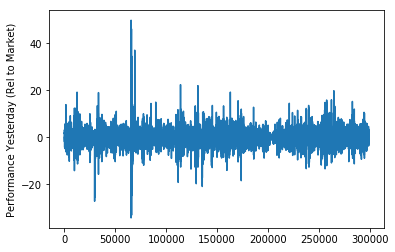

In [10]:
#Check distribution of Outperform to identify outliers
#plt.hist('Outperform', bins='auto', range=(-10,10), data=data)
plt.plot(data['Y_Outperform'])
plt.ylabel('Performance Yesterday (Rel to Market)')
#plt.boxplot(data.Outperform)


<function matplotlib.pyplot.show(*args, **kw)>

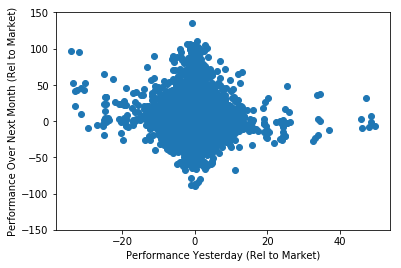

In [11]:
plt.subplot(1,1,1)
plt.scatter(x=data.Y_Outperform, y=data.Outperform_N)
plt.ylim(-150,150)
plt.xlabel('Performance Yesterday (Rel to Market)')
plt.ylabel('Performance Over Next Month (Rel to Market)')
plt.show

(-50, 50)

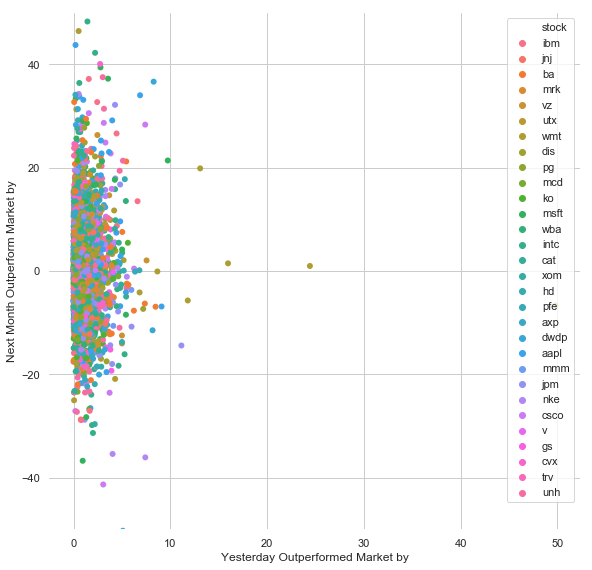

In [12]:
sns.set(style="whitegrid")

#datatemp = data.loc[(data.Y_Outperform > 0) & (data.Y_Outperform < 20) & (data.stock.isin(['pfe','aapl','wmt','mcd']))]
datasample = data.loc[data.Y_Outperform > 0].sample(5000)


# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(9.5, 9.5))
sns.despine(f, left=True, bottom=True)


sns.scatterplot(x="Y_Outperform", y="Outperform_N",
                hue="stock",
                sizes=(1, 10), linewidth=0,
                data=datasample, ax=ax)
plt.xlabel('Yesterday Outperformed Market by')
plt.ylabel('Next Month Outperform Market by')
plt.ylim(-50,50)

<function matplotlib.pyplot.show(*args, **kw)>

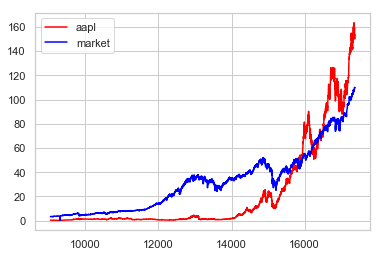

In [13]:
plt.subplot(1,1,1)
plt.plot(data.loc[data.stock=='aapl','Close'], color="red", label = 'aapl') 
plt.plot(data.loc[data.stock=='aapl','Close_M'], color="blue", label = 'market')            
plt.legend(loc = 'upper left')
plt.show

Results when Yesterday Outperformed Market by >= 5 points
---------------------------------------------------
Test Count: 1447
Control Count: 298037

Test Outperform over Next month: 2.1315272978576365
Control Outperform over Next month: 0.7547772256464803
Ttest_indResult(statistic=3.5286854224887927, pvalue=0.00043062447673064867)


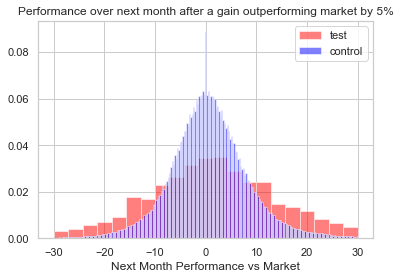

In [14]:
#Split into Control and Test Groups
data_t = []
data_c = []

#Test Group: Stocks which significantly outperformed the market the prior day.
data_t = data.loc[(data.Y_Outperform >= 5) ]

#Control Group: Stocks which performed on par with the market the prior day.
data_c = data   #.loc[(data.Y_Outperform < 2) & (data.Y_Outperform >=-2)]


#Plot Results
plt.hist(data_t.Outperform_N, bins='auto', range=(-30,30), color='red', label='test', density=True, alpha=.5 )
plt.hist(data_c.Outperform_N, bins='auto', range=(-30,30), color='blue', label='control', density=True, alpha=.5 )
plt.title('Performance over next month after a gain outperforming market by 5%')
plt.xlabel('Next Month Performance vs Market')
plt.legend(loc='upper right')

#Display T Test Results
print('Results when Yesterday Outperformed Market by >= 5 points')
print('---------------------------------------------------')
print('Test Count: ' + str(data_t.Outperform_N.count()))
print('Control Count: ' + str(data_c.Outperform_N.count()))
print('')
print('Test Outperform over Next month: ' + str(data_t.Outperform_N.mean()))
print('Control Outperform over Next month: ' + str(data_c.Outperform_N.mean()))
print(stats.ttest_ind(data_t.Outperform_N, data_c.Outperform_N, equal_var=False))

Results when Yesterday Outperformed Market by >= 10 points
---------------------------------------------------
Test Count: 164
Control Count: 298037

Test Outperform over Next month: 1.2049999999999998
Control Outperform over Next month: 0.7547772256464803
Ttest_indResult(statistic=0.31811128473762745, pvalue=0.7508075192577884)


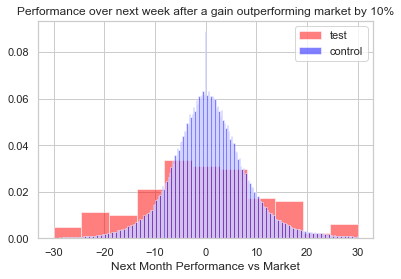

In [15]:
#Split into Control and Test Groups
data_t = []
data_c = []

#Test Group: Stocks which significantly outperformed the market the prior day.
data_t = data.loc[data.Y_Outperform >= 10]

#Control Group: Stocks which performed on par with the market the prior day.
data_c = data  #.loc[(data.Y_Outperform < 2) & (data.Y_Outperform >=-2)]


#Plot Results
plt.hist(data_t.Outperform_N, bins='auto', range=(-30,30), color='red', label='test', density=True, alpha=.5 )
plt.hist(data_c.Outperform_N, bins='auto', range=(-30,30), color='blue', label='control', density=True, alpha=.5 )
plt.title('Performance over next week after a gain outperforming market by 10%')
plt.legend(loc='upper right')
plt.xlabel('Next Month Performance vs Market')


#Display T Test Results
print('Results when Yesterday Outperformed Market by >= 10 points')
print('---------------------------------------------------')
print('Test Count: ' + str(data_t.Outperform_N.count()))
print('Control Count: ' + str(data_c.Outperform_N.count()))
print('')
print('Test Outperform over Next month: ' + str(data_t.Outperform_N.mean()))
print('Control Outperform over Next month: ' + str(data_c.Outperform_N.mean()))
print(stats.ttest_ind(data_t.Outperform_N, data_c.Outperform_N, equal_var=False))

In [16]:
results = pd.DataFrame(data=[], columns=['stock', 'Y_Outperform', 'Test Outperform', 'Control Outperform', 'Test Boost', 'P Value', 'Result', 'Test Count', 'Control Count'])

#----------------- Load Results by stock ------------------
for stock in dow30:

    data_c = []
    #Control Group: Stocks which performed on par with the market the prior day.
    data_c = data.loc[data.stock == str.lower(stock)]
    
    for x in range(21):
        #Split into Control and Test Groups
        data_t = []
        
        
        #Test Group: Stocks which significantly outperformed the market the prior day.
        data_t = data.loc[(data.Y_Outperform >= x) & (data.stock == str.lower(stock))]

        if data_t.empty == False:
            
            
            tval, pval = stats.ttest_ind(data_t.Outperform_N, data_c.Outperform_N, equal_var=False)
    
            if pval < .05:
                r = 'reject null'
            else:
                r = 'accept null (no difference)'
        
            tmean = data_t.Outperform_N.mean()
            cmean = data_c.Outperform_N.mean()
            tboost = tmean - cmean
            
            results = results.append({'stock' : str.lower(stock),
                             'Y_Outperform' : x,
                             'Test Outperform' : tmean , 
                             'Control Outperform' : cmean  ,
                             'Test Boost' : tboost,
                             'P Value' : round(pval,2),
                             'Result' : r ,
                             'Test Count' : data_t.Outperform_N.count() ,
                             'Control Count' : data_c.Outperform_N.count()}, ignore_index=True)

        
#----------------- Load Results for All combined ------------------

data_c = []
#Control Group: Stocks which performed on par with the market the prior day.
data_c = data 
        
for x in range(21):
    #Split into Control and Test Groups
    data_t = []
    
    
    #Test Group: Stocks which significantly outperformed the market the prior day.
    data_t = data.loc[(data.Y_Outperform >= x)]

    if data_t.empty == False:
            

            tval, pval = stats.ttest_ind(data_t.Outperform_N, data_c.Outperform_N, equal_var=False)
    
            if pval < .05:
                r = 'reject null'
            else:
                r = 'accept null (no difference)'
        
            tmean = data_t.Outperform_N.mean()
            cmean = data_c.Outperform_N.mean()
            tboost = tmean - cmean
            
            results = results.append({'stock' : 'all',
                             'Y_Outperform' : x,
                             'Test Outperform' : tmean , 
                             'Control Outperform' : cmean  ,
                             'Test Boost' : tboost,
                             'P Value' : round(pval,2),
                             'Result' : r ,
                             'Test Count' : data_t.Outperform_N.count() ,
                             'Control Count' : data_c.Outperform_N.count()}, ignore_index=True)

            
results[results.stock == 'all']

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,stock,Y_Outperform,Test Outperform,Control Outperform,Test Boost,P Value,Result,Test Count,Control Count
436,all,0,0.653781,0.754777,-0.100996,0.02,reject null,151748,298037
437,all,1,0.803853,0.754777,0.049075,0.35,accept null (no difference),50341,298037
438,all,2,1.124676,0.754777,0.369899,0.00,reject null,16909,298037
439,all,3,1.422481,0.754777,0.667704,0.00,reject null,6601,298037
440,all,4,1.680733,0.754777,0.925956,0.00,reject null,2946,298037
441,all,5,2.131527,0.754777,1.376750,0.00,reject null,1447,298037
442,all,6,1.886723,0.754777,1.131946,0.05,accept null (no difference),766,298037
443,all,7,1.641852,0.754777,0.887075,0.25,accept null (no difference),459,298037
444,all,8,2.015437,0.754777,1.260660,0.19,accept null (no difference),309,298037
445,all,9,1.863591,0.754777,1.108814,0.35,accept null (no difference),220,298037


Text(0,0.5,'Boost over next month')

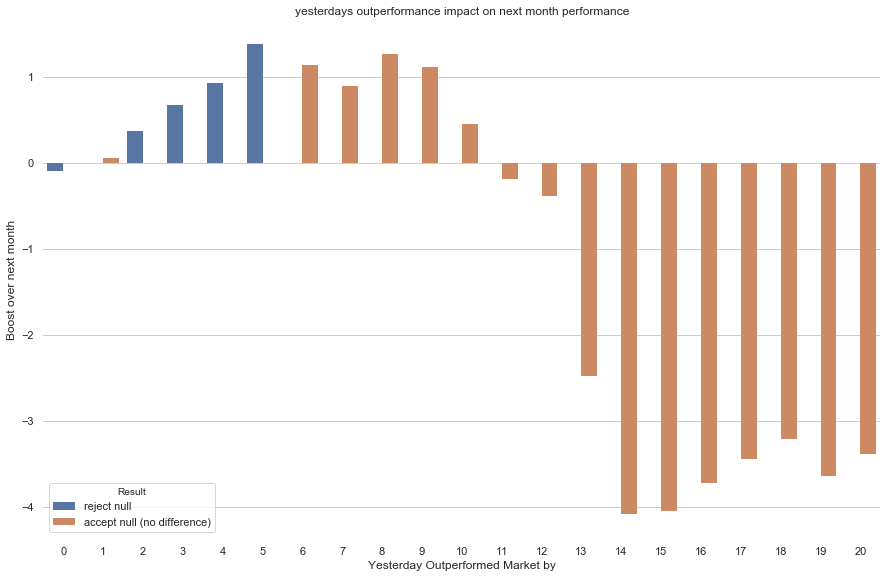

In [17]:
sns.set(style="whitegrid")


plotresults = results.loc[results.stock == 'all']

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(15, 9.5))
sns.despine(f, left=True, bottom=True)
sns.barplot(x="Y_Outperform", y="Test Boost",
                hue="Result", 
                 linewidth=0,
                data=plotresults, ax=ax)
plt.title('yesterdays outperformance impact on next month performance')
plt.xlabel('Yesterday Outperformed Market by')
plt.ylabel('Boost over next month')

Text(0,0.5,'Boost over next month')

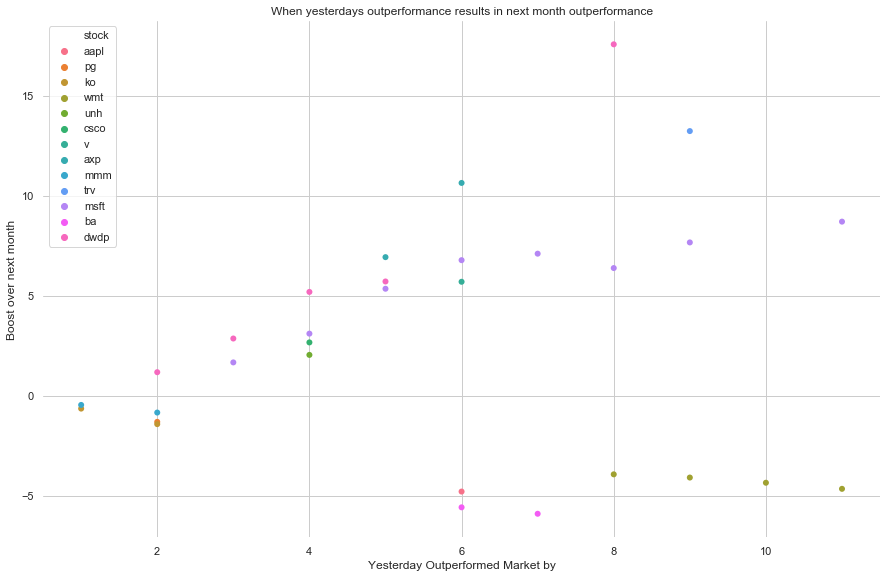

In [18]:
sns.set(style="whitegrid")


plotresults = results.loc[(results.Result == 'reject null') & (results.stock != 'all')]

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(15, 9.5))
sns.despine(f, left=True, bottom=True)
plt.title('When yesterdays outperformance results in next month outperformance')

sns.scatterplot(x="Y_Outperform", y="Test Boost",
                hue="stock", 
                 linewidth=0,
                data=plotresults, ax=ax)
plt.xlabel('Yesterday Outperformed Market by')
plt.ylabel('Boost over next month')

In [19]:
resultsd = pd.DataFrame(data=[],columns=['stock','dayofweek','dayofweek boost','PctChg', 'PctChg Control', 'P Value', 'Result'])

data_c = []
data_c = data

for x in range(5):
    

    data_t = []
    
    
    #Test Group: Stock Performance for a particular day of week
    data_t = data.loc[data.dayofweek == x]

   
    tval, pval = stats.ttest_ind(data_t.PctChg, data_c.PctChg, equal_var=False)
    
    if pval < .05:
        r = 'reject null'
    else:
        r = 'accept null (no difference)'
        
    tmean = data_t.PctChg.mean()
    cmean = data_c.PctChg.mean()
    tboost = tmean - cmean
    
    resultsd = resultsd.append({'stock' : 'all',
                        'dayofweek' : x,
                        'dayofweek boost' : tboost,
                        'PctChg' : tmean,
                        'PctChg Control' : cmean , 
                        'P Value' : round(pval,2),
                        'Result' : r }, ignore_index=True)



resultsd.head()

,stock,dayofweek,dayofweek boost,PctChg,PctChg Control,P Value,Result
0,all,0,0.019173,0.056438,0.037265,0.30,accept null (no difference)
1,all,1,0.012816,0.050081,0.037265,0.46,accept null (no difference)
2,all,2,0.025969,0.063234,0.037265,0.00,reject null
3,all,3,-0.025028,0.012237,0.037265,0.00,reject null
4,all,4,-0.032775,0.004490,0.037265,0.00,reject null


Text(0,0.5,'Boost')

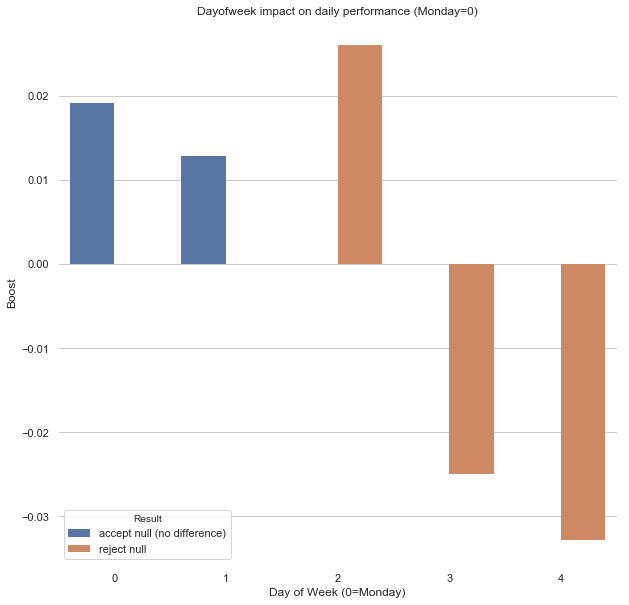

In [20]:
sns.set(style="whitegrid")


plotresults = resultsd.loc[resultsd.stock == 'all']

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
plt.title('Dayofweek impact on daily performance (Monday=0)')

sns.barplot(x="dayofweek", y="dayofweek boost",
                hue="Result", 
                 linewidth=0,
                data=plotresults, ax=ax)
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Boost')

In [ ]:
#data.loc[data['Date'].isin(['1982-01-04','1982-01-05'])] #,'1982-01-06','1982-01-07','1982-01-08','1982-01-09','1982-01-10','1982-01-11'])]